In [1]:
import pandas as pd
import numpy as np
import emoji
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import BaggingClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout,MaxPool1D, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2

from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

#### Read and analyze the dataset

In [2]:
df = pd.read_csv("D:\\Datasets\\emoji_sentiment_tweets_dataset.csv")

In [3]:
df.shape

(2000, 2)

In [4]:
df.loc[980:1010:3]

,sentiment,post
980,1,have a great
983,1,It really is uplifting and inspiring
986,1,year old i am commenting on all the new ladyli...
989,1,Just delivered my Managing the Online Customer...
992,1,well..human. That's all i
995,1,big 😍 for Anne cox 😊
998,1,thanks for the recent follow. Much appreciated...
1001,0,talking to my over driver about where I'm goin...
1004,0,There isnt a new Riverdale tonight ? 😧
1007,0,don't like how jittery caffeine makes me 😔


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  2000 non-null   int64 
 1   post       2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [6]:
df.isna().sum()

sentiment    0
post         0
dtype: int64

In [7]:
print(f'Count of positive sentiment : {df[ df.sentiment == 1 ].shape[0]}')
print(f'Count of negative sentiment : {df[ df.sentiment == 0 ].shape[0]}')

Count of positive sentiment : 1000
Count of negative sentiment : 1000


<AxesSubplot:xlabel='sentiment', ylabel='count'>

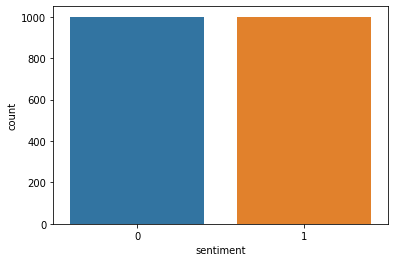

In [8]:
sns.countplot(data=df, x=df.sentiment)

#### Data cleaning and preprocessing step

In [9]:
# Retrive emojis list only

retrive_emojis = lambda word_list: [match["emoji"] for word in word_list for match in emoji.emoji_list(word)]

In [10]:
# Split text and emoji

def extract_text_and_emoji(text):
    global allchars, emoji_list
    # remove all tagging and links, not need for sentiments
    remove_keys = ('@', 'http://', '&', '#')
    clean_text = ' '.join(txt for txt in text.split() if not txt.startswith(remove_keys))
#     print(clean_text)
    
    # setup the input, get the characters and the emoji lists
    allchars = [str for str in text]
    emoji_list = retrive_emojis(text)
    
    # extract text
    clean_text = ' '.join([str for str in clean_text.split() if not any(i in str for i in emoji_list)])
    
    # extract emoji
    clean_emoji = ' '.join([str for str in text.split() if any(i in str for i in emoji_list)])
    return (clean_text, clean_emoji)

In [11]:
temp_df_emoji = []
temp_df_text = []

for text in df.post:
    temp_df_text.append(extract_text_and_emoji(text)[0])
    temp_df_emoji.append(extract_text_and_emoji(text)[1])
    
df["post_text"], df["emoji"] = temp_df_text, temp_df_emoji

In [12]:
df.head(10)

,sentiment,post,post_text,emoji
0,1,An inspiration in all aspects: Fashion,An inspiration in all aspects: Fashion,
1,1,fitness,fitness,
2,1,beauty and personality. 😊 😘 TheFashionIcon,beauty and personality. TheFashionIcon,😊 😘
3,1,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,😊
4,1,Beautiful album from the greatest unsung guita...,Beautiful album from the greatest unsung guita...,
5,1,Good luck to Rich riding for great project in ...,Good luck to Rich riding for great project in ...,
6,1,Omg he... kissed... him 😆 with joy,Omg he... kissed... him with joy,😆
7,1,😊 anniv ming and papi!!!!! 😍 😍 😊,anniv ming and papi!!!!!,😊 😍 😍 😊
8,1,thanks 😊,thanks,😊
9,1,C'mon Tweeps,C'mon Tweeps,


In [13]:
# convert emoji to same meaning text of emoji

def convert_emoji_to_text(emo):
    if len(emo) > 0:
        return emoji.demojize(emo)
    return ""

In [14]:
df["emoji_text"] = df.emoji.apply(convert_emoji_to_text)

In [18]:
convert_emoji_to_text("😔😡 I was extremely disappointed with the customer service at this store - not only were they unhelpful, but they were also rude and dismissive.")

':pensive_face::enraged_face: I was extremely disappointed with the customer service at this store - not only were they unhelpful, but they were also rude and dismissive.'

In [18]:
NON_PUNCTUATION = r"[!\"#\$%&\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~0-9]"

def remove_punctuation(text):
    no_punctuation_text = re.sub(NON_PUNCTUATION, " ", text, 0, re.MULTILINE)
    return no_punctuation_text

df["clean_emoji_text"] = df["emoji_text"].apply(remove_punctuation)

**Remove Twitter handles:** Twitter handles start with '@' and are used to mention other users. These do not add any value to the sentiment analysis and can be removed. You can use regular expressions to remove these handles

In [19]:
def remove_twitter_handles(text):
    return re.sub(r'@[A-Za-z0-9]+', '', text)

df["clean_post"] = df["post_text"].apply(remove_twitter_handles)

**Remove URLs:** URLs are often included in tweets and can be removed as they do not contribute to sentiment analysis. You can use regular expressions to remove URLs.

In [20]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

df["clean_post"] = df["clean_post"].apply(remove_html_tags)

**Remove special characters and punctuation:** Special characters and punctuation marks can also be removed as they do not add any meaning to sentiment analysis. You can use regular expressions to remove them.

In [21]:
df["clean_post"] = df["clean_post"].apply(remove_punctuation)

**Handling abbreviations:** Twitter users often use abbreviations like "lol", "omg", etc. These can be expanded to their full form to avoid any issues with sentiment analysis. You can use dictionaries or regular expressions to expand abbreviations.

In [22]:
abbreviations = {
    'lol': 'laugh out loud',
    'lmao': 'laughing my ass off',
    'rofl': 'rolling on the floor laughing',
    'omg': 'oh my god',
    'wtf': 'what the fuck',
    'fml': 'fuck my life',
    'smh': 'shaking my head',
    'btw': 'by the way',
    'imho': 'in my humble opinion',
    'idk': 'I do not know',
    'rn': 'right now',
    'ily': 'I love you',
    'tbh': 'to be honest',
    'ig': 'I guess',
    'bae': 'before anyone else',
    'yolo': 'you only live once',
    'fomo': 'fear of missing out',
    'tmi': 'too much information',
    'afk': 'away from keyboard',
    'afaik': 'as far as I know',
    'brb': 'be right back',
    'ftw': 'for the win',
    'hmu': 'hit me up',
    'idc': 'I do not care',
    'ikr': 'I know, right?',
    'jk': 'just kidding',
    'nbd': 'no big deal',
    'np': 'no problem',
    'omw': 'on my way',
    'ppl': 'people',
    'rt': 'retweet',
    'srsly': 'seriously',
    'tbt': 'throwback Thursday',
    'tg': 'thank god',
    'tgif': 'thank god it is Friday',
    'thx': 'thanks',
    'ttyl': 'talk to you later',
    'wyd': 'what you doing?',
    'yw': 'you are welcome',
}

def handling_abbreviations(text):
    return ' '.join([abbreviations.get(word.lower(), word) for word in text.split()])

df["clean_post"] = df["clean_post"].apply(handling_abbreviations)

**POS tagging** involves labeling each word in a text with its corresponding part of speech (e.g., noun, verb, adjective, etc.), which can be useful for many tasks, including sentiment analysis.

**Lemmatization:** Stemming and lemmatization can help in reducing the number of unique words and bring together words with similar meanings. You can use libraries like NLTK for stemming and lemmatization.

In [23]:
lemmatizer = WordNetLemmatizer()

def get_pos(tag):
    if tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:
        return 'v'
    elif tag in ["JJ","JJR","JJS"]:
        return 'a'
    elif tag in ["RB","RBR","RBS"]:
        return 'r'
    else:
        return 'n'

def do_lemmatization(review):
    lemma_new = ""
    word_list = TreebankWordTokenizer().tokenize(review)
    tags = nltk.pos_tag(word_list)
    for word, tag in tags:
        if tag in ["JJ","JJR","JJS","NN","NNS","NNP","NNPS","RB","RBR","RBS","UH","VB","VBD","VBG","VBN","VBP","VBZ"]:
            word = word.lower()
            if tag in ["JJR","JJS"]:
                lemma = lemmatizer.lemmatize(word)
            lemma = lemmatizer.lemmatize(word,pos=get_pos(tag))
            lemma_new = lemma_new + " " + lemma
    return lemma_new

df["clean_post"] = df["clean_post"].apply(do_lemmatization)

In [24]:
df["clean_emoji_text"] = df["clean_emoji_text"].apply(do_lemmatization)

**Remove stop words:** Stop words are common words like "the", "is", "and", etc., which do not add any value to sentiment analysis. You can use the NLTK library to remove stop words.

In [26]:
stop_words = stopwords.words('english')

temp_stop_words = ["not","no",'do','very','don',"don't","ain","aren","aren't","couldn","couldn't",'didn',"didn't",'doesn',"doesn't",'hadn',"hadn't",'hasn',"hasn't",'haven',"haven't",'isn',"isn't",'mightn',"mightn't",'mustn',"mustn't",'needn',"needn't",'shan',"shan't",'shouldn',"shouldn't",'wasn',"wasn't",'weren',"weren't",'won',"won't",'wouldn',"wouldn't"]
for sword in temp_stop_words:
    if sword in stop_words:
        stop_words.remove(sword)

**Vectorization**

In [27]:
# TFIDF vectorizer

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True,
                            strip_accents='ascii', stop_words=stop_words)

In [28]:
y = df.sentiment

X = vectorizer.fit_transform(df.clean_post +" "+ df.clean_emoji_text)

print(y.shape)
print(X.shape)

(2000,)
(2000, 2990)


#### Split the dataset into training and testing

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=6)

#### Naive Bayes Classifiers

In [31]:
# we will train a naive bayes classifier
m_nb = MultinomialNB()
b_nb = BernoulliNB()

m_nb.fit(X_train, y_train)
b_nb.fit(X_train, y_train)

BernoulliNB()

In [32]:
print("Multinomial Naive Bayes Algorithm")
print(f' Training accuracy is {round(m_nb.score(X_train, y_train) * 100,2)}%')
print(f' Testing accuracy is {round(m_nb.score(X_test, y_test) * 100,2)}%')

print()
print("Bernoulli Naive Bayes Algorithm")
print(f' Training accuracy is {round(b_nb.score(X_train, y_train) * 100,2)}%')
print(f' Testing accuracy is {round(b_nb.score(X_test, y_test) * 100,2)}%')

y_pred_m_nb = m_nb.predict(X_test)
y_pred_b_nb = b_nb.predict(X_test)

print()
accuracy = accuracy_score(y_test, y_pred_m_nb)
print("Accuracy of MultinomialNB :", accuracy)
print()
accuracy = accuracy_score(y_test, y_pred_b_nb)
print("Accuracy of BernoulliNB :", accuracy)

Multinomial Naive Bayes Algorithm
 Training accuracy is 96.5%
 Testing accuracy is 90.25%

Bernoulli Naive Bayes Algorithm
 Training accuracy is 95.31%
 Testing accuracy is 91.0%

Accuracy of MultinomialNB : 0.9025

Accuracy of BernoulliNB : 0.91


**The confusion matrix** shows that the model correctly classified 207 instances of the first class (usually represented as a negative class) and 157 instances of the second class (usually represented as a positive class). It misclassified 9 instances of the first class as the second class (false positives) and 27 instances of the second class as the first class (false negatives).

In [39]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_b_nb)
print("Confusion Matrix of Bernoulli Naive Bayes Algorithm ")
print(cm)

Confusion Matrix of Bernoulli Naive Bayes Algorithm 
[[207   9]
 [ 27 157]]


In [40]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_m_nb)
print("Confusion Matrix of Multinomial Naive Bayes Algorithm ")
print(cm)

Confusion Matrix of Multinomial Naive Bayes Algorithm 
[[199  17]
 [ 22 162]]


In [37]:
# Convert predictions to binary class labels
y_pred = (y_pred_b_nb > 0.5)

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred.astype(int), target_names=["negative", "positive"])
print("Classfication Report of Bernoulli Naive Bayes Algorithm ")
print()
print(report)

Classfication Report of Bernoulli Naive Bayes Algorithm 

              precision    recall  f1-score   support

    negative       0.88      0.96      0.92       216
    positive       0.95      0.85      0.90       184

    accuracy                           0.91       400
   macro avg       0.92      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



In [38]:
# Convert predictions to binary class labels
y_pred = (y_pred_m_nb > 0.5)

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred.astype(int), target_names=["negative", "positive"])
print("Classfication Report of Multinomial Naive Bayes Algorithm ")
print()
print(report)

Classfication Report of Multinomial Naive Bayes Algorithm 

              precision    recall  f1-score   support

    negative       0.90      0.92      0.91       216
    positive       0.91      0.88      0.89       184

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



**Binary cross-entropy loss** is used to measure the dissimilarity between the predicted probabilities and the true labels.

In [47]:
y_pred_b_nb = (y_pred_b_nb > 0.5)

epsilon = 1e-15 # a very small number
y_pred_b_nb = np.clip(y_pred_b_nb, epsilon, 1 - epsilon)
y_pred_b_nb = y_pred_b_nb.astype(float) # convert to float type
loss = -1 * (y_test * np.log(y_pred_b_nb) + (1 - y_test) * np.log(1 - y_pred_b_nb))
avg_loss = np.mean(loss)
print(f'Loss value for Bernoulli NB is {avg_loss}')

Loss value for Bernoulli NB is 3.1085078664841417


In [48]:
y_pred_m_nb = (y_pred_m_nb > 0.5)

epsilon = 1e-15 # a very small number
y_pred_m_nb = np.clip(y_pred_m_nb, epsilon, 1 - epsilon)
y_pred_m_nb = y_pred_m_nb.astype(float) # convert to float type
loss = -1 * (y_test * np.log(y_pred_m_nb) + (1 - y_test) * np.log(1 - y_pred_m_nb))
avg_loss = np.mean(loss)
print(f'Loss value for Bernoulli NB is {avg_loss}')

Loss value for Bernoulli NB is 3.367564681394575


**Learning curve** is a graphical representation of how the performance of a model changes as the amount of training data increases. It plots the training and validation/test set performance of a model as a function of the amount of training data used to train the model.

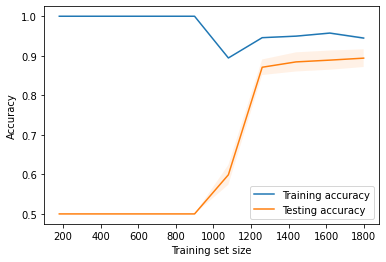

In [49]:
# Vary the size of the training set
train_sizes, train_scores, test_scores = learning_curve(b_nb, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Testing accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

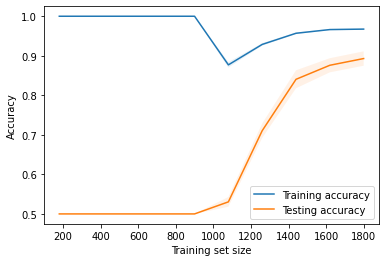

In [50]:
# Vary the size of the training set
train_sizes, train_scores, test_scores = learning_curve(m_nb, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Testing accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

#### Support Vector Machine

In [51]:
svm_model = SVC(kernel='linear')

svm_model.fit(X_train, y_train)

SVC(kernel='linear')

In [52]:
print(f'Training accuracy is {round(svm_model.score(X_train, y_train) * 100,2)}%')
print(f'Testing accuracy is {round(svm_model.score(X_test, y_test) * 100,2)}%')

y_pred = svm_model.predict(X_test)
print()
print(f'Accuracy is ', accuracy_score(y_test, y_pred) )

Training accuracy is 98.25%
Testing accuracy is 90.0%

Accuracy is  0.9


In [53]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[189  27]
 [ 13 171]]


In [54]:
# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred.astype(int))
print("Classfication Report ")
print()
print(report)

Classfication Report 

              precision    recall  f1-score   support

           0       0.94      0.88      0.90       216
           1       0.86      0.93      0.90       184

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



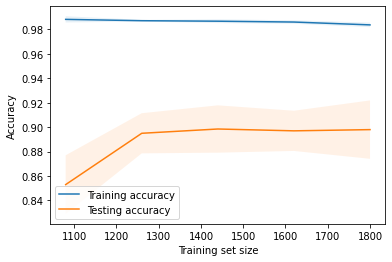

In [55]:
# Vary the size of the training set
train_sizes, train_scores, test_scores = learning_curve(svm_model, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate the mean and standard deviation of the training and testing scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Testing accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

In [57]:
epsilon = 1e-15 # a very small number
y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
y_pred = y_pred.astype(float) # convert to float type
loss = -1 * (y_test * np.log(y_pred) + (1 - y_test) * np.log(1 - y_pred))
avg_loss = np.mean(loss)
print(f'Loss value is {avg_loss}')

Loss value is 3.453931612317607


#### CNN

In [58]:
def create_cnn_model(max_features):
    
    model = Sequential()

    model.add(Conv1D(256, 3, activation='relu', padding='same', input_shape=(max_features,1), kernel_regularizer=l2(0.01)))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPool1D(2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    
    model.summary()
    
    return model

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2,random_state=6)

# reshape the input data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [60]:
cnn_model = create_cnn_model(X.shape[1])

cnn_model.fit(X_train, y_train, epochs=10, batch_size=128)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2990, 256)         1024      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1495, 256)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1495, 256)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1495, 128)         98432     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 747, 128)         0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 747, 128)          0

In [61]:
loss, accuracy = cnn_model.evaluate(X_train, y_train, verbose=0)
print(f'Train accuracy: {accuracy} and Loss : {loss}')

loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {accuracy} and Loss : {loss}')

Train accuracy: 0.9962499737739563 and Loss : 0.0209535900503397
Test accuracy: 0.9049999713897705 and Loss : 0.3873519003391266


In [62]:
# Make predictions on test data
y_pred = cnn_model.predict(X_test)

# Convert predictions to binary class labels
y_pred = (y_pred > 0.5)

# Calculate precision, recall, and F1-score
report = classification_report(y_test, y_pred.astype(int))
print("Classfication Report ")
print()
print(report)

Classfication Report 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       216
           1       0.91      0.89      0.90       184

    accuracy                           0.91       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.91      0.90       400



In [63]:
# calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

Confusion Matrix
[[199  17]
 [ 21 163]]


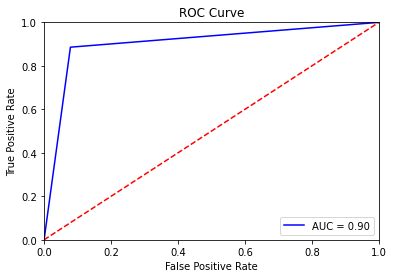

In [66]:
from sklearn.metrics import roc_curve, auc

# calculate false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(y_test, y_pred)

# calculate AUC
roc_auc = auc(fpr, tpr)

# plot ROC curve
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()